In [21]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from typing import Tuple
import numpy as np
import requests
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt

#### LOADING THE MODEL
from torchvision.models import resnet18

# Normalization parameters
mean = [0.2980, 0.2962, 0.2987]
std = [0.2886, 0.2875, 0.2889]

# Define transformations
transform = transforms.Compose([
    # transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Load the model
model = resnet18(pretrained=False)
model.fc = torch.nn.Linear(512, 44)

ckpt = torch.load("./01_MIA.pt", map_location="cpu")
model.load_state_dict(ckpt)
model.eval()  # Set the model to evaluation mode

#### DATASETS
class TaskDataset(Dataset):
    def __init__(self, transform=None):
        self.ids = []
        self.imgs = []
        self.labels = []
        self.transform = transform

    def __getitem__(self, index) -> Tuple[int, torch.Tensor, int]:
        id_ = self.ids[index]
        img = self.imgs[index]
        if not self.transform is None:
            img = self.transform(img)
        label = self.labels[index]
        return id_, img, label

    def __len__(self):
        return len(self.ids)


class MembershipDataset(TaskDataset):
    def __init__(self, transform=None):
        super().__init__(transform)
        self.membership = []

    def __getitem__(self, index) -> Tuple[int, torch.Tensor, int, int]:
        id_, img, label = super().__getitem__(index)
        return id_, img, label, self.membership[index]

In [22]:
def collate_fn(batch):
    filtered_batch = []
    for sample in batch:
        if sample[0] is None or sample[1] is None or sample[2] is None:
            print("Skipping invalid sample:", sample)
            continue
        filtered_batch.append(sample[:3])
    return torch.utils.data.default_collate(filtered_batch)

# Load the datasets
pub_data = torch.load("./pub.pt", weights_only=False)
priv_data = torch.load("./priv_out.pt", weights_only=False)

In [23]:
# Add transform to datasets
pub_data.transform = transform
priv_data.transform = transform

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

Using device: cpu


In [24]:
# Function to extract features for membership inference
def extract_features(model, dataset, device):
    dataloader = DataLoader(dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)
    
    all_ids = []
    all_labels = []
    all_features = []
    
    # Define features we want to compute
    with torch.no_grad():
        for batch in dataloader:
            if len(batch) == 4:
                batch_ids, batch_imgs, batch_labels, _ = batch  # discard membership flag
            else:
                batch_ids, batch_imgs, batch_labels = batch

            batch_imgs = batch_imgs.to(device)
            batch_labels = batch_labels.to(device)
            
            # Forward pass
            outputs = model(batch_imgs)
            softmax_outputs = torch.nn.functional.softmax(outputs, dim=1)
            
            # Calculate prediction entropy
            prediction_entropy = -torch.sum(softmax_outputs * torch.log(softmax_outputs + 1e-10), dim=1)
            
            # Calculate loss
            loss_per_sample = torch.nn.functional.cross_entropy(outputs, batch_labels, reduction='none')
            
            # Calculate confidence scores
            max_prob, predicted = torch.max(softmax_outputs, dim=1)
            correct_prob = softmax_outputs[torch.arange(batch_labels.size(0)), batch_labels]
            
            # Calculate modified entropy (specific to membership inference)
            modified_entropy = prediction_entropy * (1 - correct_prob)
            
            # Calculate gradient magnitude proxy
            logits_with_true_label = outputs[torch.arange(batch_labels.size(0)), batch_labels]
            gradient_proxy = torch.abs(1 - logits_with_true_label)
            
            # Calculate confidence margin (difference between highest and second highest)
            sorted_probs, _ = torch.sort(softmax_outputs, dim=1, descending=True)
            margin = sorted_probs[:, 0] - sorted_probs[:, 1]
            
            # Calculate class probabilities variance
            variance = torch.var(softmax_outputs, dim=1)
            
            # Prediction correctness
            correctness = (predicted == batch_labels).float()
            
            # Combine features
            batch_features = torch.stack([
                loss_per_sample,  # Loss
                max_prob,         # Maximum probability
                correct_prob,     # Probability of correct class
                prediction_entropy,  # Prediction entropy
                modified_entropy,    # Modified entropy
                gradient_proxy,      # Gradient magnitude proxy
                margin,              # Confidence margin
                variance,            # Class probabilities variance
                correctness          # Correctness of prediction
            ], dim=1)
            
            # Add augmented features for potentially better signal
            # Ratio of correct probability to max probability
            ratio = correct_prob / (max_prob + 1e-10)
            # Product of correct probability and (1 - entropy)
            product = correct_prob * (1 - prediction_entropy / torch.log(torch.tensor(outputs.shape[1], dtype=torch.float)))
            
            # Add these to batch_features
            batch_features = torch.cat([
                batch_features,
                ratio.unsqueeze(1),
                product.unsqueeze(1)
            ], dim=1)
            
            all_ids.extend(batch_ids.tolist())
            all_labels.extend(batch_labels.cpu().tolist())
            all_features.append(batch_features.cpu())
    
    # Concatenate all batches
    all_features = torch.cat(all_features, dim=0).numpy()
    
    return all_ids, all_features, all_labels

# Extract features for public and private datasets
print("Extracting features for public dataset...")
pub_ids, pub_features, pub_labels = extract_features(model, pub_data, device)
print("Extracting features for private dataset...")
priv_ids, priv_features, priv_labels = extract_features(model, priv_data, device)

Extracting features for public dataset...
Extracting features for private dataset...


In [25]:
# Get membership information for public dataset
pub_memberships = [pub_data.membership[i] for i in range(len(pub_data))]

# Prepare data for training the attack model
X_train = pub_features
y_train = np.array(pub_memberships)

# Train multiple models and ensemble them for better performance
print("Training attack models...")
models = {
    'rf': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'gb': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
}

Training attack models...


In [26]:
# Validate models using cross-validation
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    print(f"{name} CV AUC: {scores.mean():.4f} ± {scores.std():.4f}")

# Train the final models on the full public dataset
trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model

# Feature importance analysis
if hasattr(trained_models['rf'], 'feature_importances_'):
    feature_names = [
        'Loss', 'Max Prob', 'Correct Prob', 'Entropy', 'Modified Entropy',
        'Gradient Proxy', 'Margin', 'Variance', 'Correctness',
        'Ratio (Correct/Max)', 'Product (Correct * (1-Entropy))'
    ]
    importances = trained_models['rf'].feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title('Feature Importances for Membership Inference')
    plt.bar(range(X_train.shape[1]), importances[indices], align='center')
    plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.close()
    
    print("Top 5 important features:")
    for i in range(5):
        print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# Predict membership probabilities for private dataset using all models
priv_predictions = {}
for name, model in trained_models.items():
    priv_predictions[name] = model.predict_proba(priv_features)[:, 1]

# Ensemble the predictions (simple average)
final_scores = np.mean([priv_predictions[name] for name in trained_models.keys()], axis=0)

# Prepare submission
df = pd.DataFrame(
    {
        "ids": priv_data.ids,
        "score": final_scores,
    }
)

# Save submission file
df.to_csv("submission.csv", index=None)

rf CV AUC: 0.6407 ± 0.0110
gb CV AUC: 0.6398 ± 0.0109
Top 5 important features:
1. Product (Correct * (1-Entropy)): 0.1889
2. Correct Prob: 0.1734
3. Loss: 0.1457
4. Ratio (Correct/Max): 0.1203
5. Gradient Proxy: 0.0677


Test AUC: 0.7056
TPR@FPR=0.05: 0.1713
Analysis complete and submission file generated.
To submit your scores, use the following code after replacing TOKEN with your team's token:
response = requests.post("http://34.122.51.94:9090/mia", files={"file": open("submission.csv", "rb")}, headers={"token": "TOKEN"})
print(response.json())


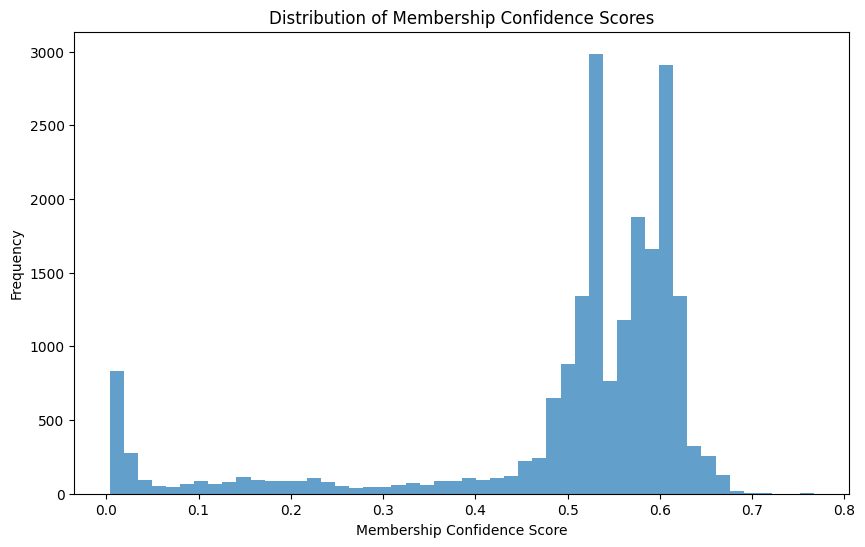

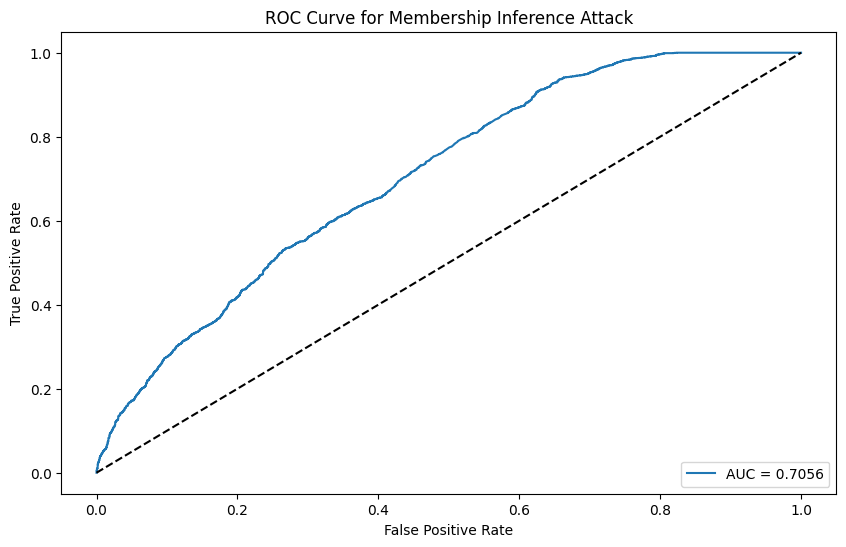

In [29]:
# Plot the distribution of membership scores
plt.figure(figsize=(10, 6))
plt.hist(final_scores, bins=50, alpha=0.7)
plt.title('Distribution of Membership Confidence Scores')
plt.xlabel('Membership Confidence Score')
plt.ylabel('Frequency')
plt.savefig('score_distribution.png')

# If we had ground truth for private dataset, we could evaluate here
# But since we don't, we'll evaluate on the public dataset instead
# by using part of the public dataset as validation

# Split public dataset for validation
X_val_split, X_test_split, y_val_split, y_test_split = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42
)

# Ensemble predictions on the test split
test_predictions = {}
for name, model in trained_models.items():
    test_predictions[name] = model.predict_proba(X_test_split)[:, 1]

ensemble_test_scores = np.mean([test_predictions[name] for name in trained_models.keys()], axis=0)

# Calculate metrics
auc_score = roc_auc_score(y_test_split, ensemble_test_scores)
fpr, tpr, thresholds = roc_curve(y_test_split, ensemble_test_scores)

# Find TPR at FPR=0.05
idx_fpr_005 = np.argmin(np.abs(fpr - 0.05))
tpr_at_fpr_005 = tpr[idx_fpr_005]

print(f"Test AUC: {auc_score:.4f}")
print(f"TPR@FPR=0.05: {tpr_at_fpr_005:.4f}")

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Membership Inference Attack')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png')

print("Analysis complete and submission file generated.")
print("To submit your scores, use the following code after replacing TOKEN with your team's token:")
print("response = requests.post(\"http://34.122.51.94:9090/mia\", files={\"file\": open(\"submission.csv\", \"rb\")}, headers={\"token\": \"TOKEN\"})")
print("print(response.json())")

In [27]:
print("./submission.csv")

./submission.csv


In [28]:
response = requests.post("http://34.122.51.94:9090/mia", files={"file": open("submission.csv", "rb")}, headers={"token": "96005201"})
print(response.json())

{'TPR@FPR=0.05': 0.07633333333333334, 'AUC': 0.6405185555555556}
